In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Test.csv
Train.csv



This is a demonstration of application of Principle Component on the Dataset Big Mart sale. Beofre we apply PCA, we have to do feature engineering, converting all features into numerical data for easier analysis.

In [2]:
#Loading data.
train=pd.read_csv("../input/Train.csv")
test=pd.read_csv("../input/Test.csv")

In [3]:
print("Rows and Columns in training set:", train.shape)

Rows and Columns in training set: (8523, 12)


In [4]:
print("Rows and columns in testing set: ", test.shape)

Rows and columns in testing set:  (5681, 11)


In [5]:
#getting familiar with the structure of dataset.
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

Let's check for missing values in the dataset.

In [6]:
for col in train:
    val=train[col].isnull().sum()
    if val>0.0:
        print("Number of missing values in column ",col,":",val)
    #else:
     #   print("Number of values in column ",col,":",85223-val)

Number of missing values in column  Item_Weight : 1463
Number of missing values in column  Outlet_Size : 2410


In [7]:
for col in test:
    val=test[col].isnull().sum()
    if val>0.0:
        print("Number of missing values in column ",col,":",val)
    #else:
     #   print("Number of values in column ",col,":",5681-val)

Number of missing values in column  Item_Weight : 976
Number of missing values in column  Outlet_Size : 1606


For better prediction, we will be filling the missing values. Missing values can be filled by finding it's correlation with other features, sometimes the correlation is so propotional that we directly fill in the missing values. Another solution to this problem could be filling the missing datas with median value or mode value of the feature as would make more sense. 

Heatmap to predict the correlation of Item weight and Outlet size. Heatmap doesn't work for catatogorical features, which could result in missing correlation between the missing values and the catagorical features, if there would be any relationship. So we first convert the catagorical features into numerical.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Here, we find that there are 7 categorical features:
Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type
Let's use mapping to convert them into numerical data.

In [9]:
print(train["Item_Fat_Content"].value_counts())
print(train["Item_Type"].value_counts())
print(train["Outlet_Identifier"].value_counts())
print(train["Outlet_Size"].value_counts())
print(train["Outlet_Location_Type"].value_counts())
print(train["Outlet_Type"].value_counts())

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
Supermarket Type1    5577
Grocer

In [10]:
combine=[test, train]
content_mapping = {'Low Fat': 1, 'Regular': 2, 'LF': 3, 'reg': 4, 'low fat': 5}
item_mapping = {'Fruits and Vegetables': 1, 'Snack Foods': 2, 'Household': 3, 'Frozen Foods': 4, 'Dairy': 5, 'Canned':6, 'Baking Goods':7, 'Health and Hygiene':8, 'Soft Drinks':9, 'Meat':10, 'Breads':11, 'Hard Drinks':12, 'Others':13, 'Starchy Foods':14, 'Breakfast':15, 'Seafood':16}
outletIdentifier_mapping ={'OUT027': 27, 'OUT013': 13, 'OUT046': 46, 'OUT035': 35, 'OUT049': 49, 'OUT045':45, 'OUT018':18, 'OUT017':17, 'OUT010':10, 'OUT019':19}
outlet_mapping = {'High': 1, 'Medium': 2, 'Small': 3}
Location_mapping = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3}
Type_mapping = {'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3, 'Grocery Store':4}
for dataset in combine:
    dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].map(content_mapping)
    dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].fillna(0)
    dataset['Item_Type'] = dataset['Item_Type'].map(item_mapping)
    dataset['Item_Type'] = dataset['Item_Type'].fillna(0)
    dataset['Outlet_Size'] = dataset['Outlet_Size'].map(outlet_mapping)
    dataset['Outlet_Size'] = dataset['Outlet_Size'].fillna(0) 
    dataset['Outlet_Identifier'] = dataset['Outlet_Identifier'].map(outletIdentifier_mapping)
    dataset['Outlet_Identifier'] = dataset['Outlet_Identifier'].fillna(0)
    dataset['Outlet_Location_Type'] = dataset['Outlet_Location_Type'].map(Location_mapping)
    dataset['Outlet_Location_Type'] = dataset['Outlet_Location_Type'].fillna(0)
    dataset['Outlet_Type'] = dataset['Outlet_Type'].map(Type_mapping)
    dataset['Outlet_Type'] = dataset['Outlet_Type'].fillna(0)

train.head()
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,1,0.007565,2,107.8622,49,1999,2.0,1,1
1,FDW14,8.300,4,0.038428,5,87.3198,17,2007,0.0,2,1
2,NCN55,14.600,1,0.099575,13,241.7538,10,1998,0.0,3,4
3,FDQ58,7.315,1,0.015388,2,155.0340,17,2007,0.0,2,1
4,FDY38,NaN,2,0.118599,5,234.2300,27,1985,2.0,3,3


Thus, through mapping, we have converted all except Item_Identifier into numeric data. Let's use cat.codes accessor to convert Item_Identifier into numeric data. But cat.codes works only on category datatype, so we'll first convert Item_Identifier into a category type and then use cat.codes to convert the last categorical feature to numeric.

In [11]:
train["Item_Identifier"] = train["Item_Identifier"].astype('category')
train.dtypes

Item_Identifier              category
Item_Weight                   float64
Item_Fat_Content                int64
Item_Visibility               float64
Item_Type                       int64
Item_MRP                      float64
Outlet_Identifier               int64
Outlet_Establishment_Year       int64
Outlet_Size                   float64
Outlet_Location_Type            int64
Outlet_Type                     int64
Item_Outlet_Sales             float64
dtype: object

In [12]:
#converting categorical data to numeric.
train["Item_Identifier"] = train["Item_Identifier"].cat.codes
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,1,0.016047,5,249.8092,49,1999,2.0,1,1,3735.1380
1,8,5.92,2,0.019278,9,48.2692,18,2009,2.0,3,2,443.4228
2,662,17.50,1,0.016760,10,141.6180,49,1999,2.0,1,1,2097.2700
3,1121,19.20,2,0.000000,1,182.0950,10,1998,0.0,3,4,732.3800
4,1297,8.93,1,0.000000,3,53.8614,13,1987,1.0,3,1,994.7052


In [13]:
test["Item_Identifier"] = test["Item_Identifier"].astype('category')
test.dtypes

Item_Identifier              category
Item_Weight                   float64
Item_Fat_Content                int64
Item_Visibility               float64
Item_Type                       int64
Item_MRP                      float64
Outlet_Identifier               int64
Outlet_Establishment_Year       int64
Outlet_Size                   float64
Outlet_Location_Type            int64
Outlet_Type                     int64
dtype: object

In [14]:
#converting categorical data to numeric.
test["Item_Identifier"] = test["Item_Identifier"].cat.codes
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1103,20.750,1,0.007565,2,107.8622,49,1999,2.0,1,1
1,1067,8.300,4,0.038428,5,87.3198,17,2007,0.0,2,1
2,1406,14.600,1,0.099575,13,241.7538,10,1998,0.0,3,4
3,809,7.315,1,0.015388,2,155.0340,17,2007,0.0,2,1
4,1184,NaN,2,0.118599,5,234.2300,27,1985,2.0,3,3


Thus, we have successfully converted all the catagorical features into numeric. Now it's time to find correlation between various features.

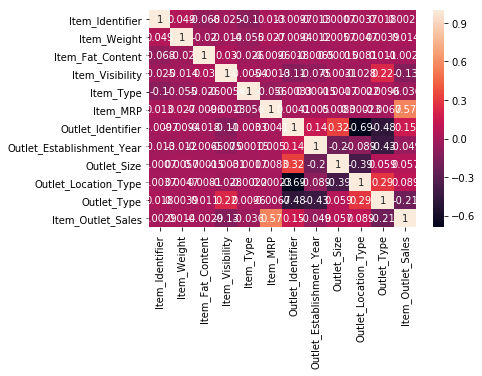

In [15]:
#Overall Correlation
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(train.corr(),annot=True)
plt.show()

From above heatmap, we conclude that Outlet_Size as a positive correlation with Outlet Identifier.

In [16]:
pd.crosstab(train['Outlet_Size'], train['Outlet_Identifier'])

Outlet_Identifier,10,13,17,18,19,27,35,45,46,49
Outlet_Size,,,,,,,,,,
0.0,555,0,926,0,0,0,0,929,0,0
1.0,0,932,0,0,0,0,0,0,0,0
2.0,0,0,0,928,0,935,0,0,0,930
3.0,0,0,0,0,528,0,930,0,930,0


from above,if table, we can safely conclude that, outlet_identifier=10,17,45, outlet_size=0
if 13 1
if 18,27,49 2
if 19,35,46 3
so, we fill the missing values acordingly

In [17]:
for row in train.itertuples(index=True, name='Pandas'):
    if row[9] is None:
        if(row[7]==10 or row[7]==17 or row[7]==45):
            train.loc[row.Index, 'Outlet_Size'] = 0
    else:
        if(row[7]==13):
            train.loc[row.Index, 'Outlet_Size'] =1
        else:
            if(row[7]==18 or row[7]==27 or row[7]==49):
                train.loc[row.Index, 'Outlet_Size'] =2
            else:
                if(row[7]==19 or row[7]==35 or row[7]==46):
                    train.loc[row.Index, 'Outlet_Size'] =3

In [18]:
for row in test.itertuples(index=True, name='Pandas'):
    if row[9] is None:
        if(row[7]==10 or row[7]==17 or row[7]==45):
            test.loc[row.Index, 'Outlet_Size'] = 0
    else:
        if(row[7]==13):
            test.loc[row.Index, 'Outlet_Size'] =1
        else:
            if(row[7]==18 or row[7]==27 or row[7]==49):
                test.loc[row.Index, 'Outlet_Size'] =2
            else:
                if(row[7]==19 or row[7]==35 or row[7]==46):
                    test.loc[row.Index, 'Outlet_Size'] =3

Now, having filled the Outlet_size column, we are left with Item_Weight. From the heatmap, we see that Item_weight don't really have any positive relation with any of other feature, so let's fill it's missing values with the median value of each column.

In [19]:
train['Item_Weight'].fillna(train['Item_Weight'].dropna().median(), inplace=True)

In [20]:
test['Item_Weight'].fillna(test['Item_Weight'].dropna().median(), inplace=True)

Now, having dealt with the catagorical values and the missing values, now we are left with scaling the dataset to carry out our PCA algorithm. We have PCA method in python in sklearn to carry it out implicitly, but there we have implemented PCA algorithm from scratch to understand the working of PCA algorithm. It requires som background knowledge of Linear algebra

In [21]:
import sklearn.preprocessing as preprocess
X_train = preprocess.scale(train)
X_test = preprocess.scale(test)

**PCA Algorithm.**

After having dealt with the missing values and categorical values, it's time to train a model with our data. But before that, let's learn about an useful algorithm, PCA which helps us in data visualization and dimentionality reduction. 

PCA algorithm aims to provide a mention for better visualization of data, finding correlation between features and in dimensionality reduction by finding out the most significant in describing the full dataset.

Ours is a 11 dimenional data. OUt of the 12, 11 are features and one is ouyput variable.

Let's find the mean of each feature which are actually the dimensions of the dataset.

In [22]:
mean_Identifier = train["Item_Identifier"].mean()
mean_Weight = train["Item_Weight"].mean()
mean_Fat_Content = train["Item_Fat_Content"].mean()
mean_Visibility = train["Item_Visibility"].mean()
mean_Type = train["Item_Type"].mean()
mean_MRP = train["Item_MRP"].mean()
mean_OIdentifier = train["Outlet_Identifier"].mean()
mean_Year = train["Outlet_Establishment_Year"].mean()
mean_Size = train["Outlet_Size"].mean()
mean_Location = train["Outlet_Location_Type"].mean()
mean_Type = train["Item_Type"].mean()

print(mean_Identifier)
print(mean_Weight)
print(mean_Fat_Content)
print(mean_Visibility)
print(mean_Type)
print(mean_MRP)
print(mean_OIdentifier)
print(mean_Year)
print(mean_Size)
print(mean_Location)
print(mean_Type)

779.714889124
12.813419570574444
1.5068637803590286
0.06613202877895127
5.433884782353632
140.9927819781768
29.108764519535374
1997.8318667135984
1.6053032969611638
2.1128710547929135
5.433884782353632


In [23]:
mean_vector = np.array([[mean_Identifier,mean_Weight,mean_Fat_Content,mean_Visibility,mean_Type,mean_MRP,mean_OIdentifier,mean_Year,mean_Size,mean_Location,mean_Type]])
print('Mean Vector:\n', mean_vector)
mean_vector.shape

Mean Vector:
 [[  7.79714889e+02   1.28134196e+01   1.50686378e+00   6.61320288e-02
    5.43388478e+00   1.40992782e+02   2.91087645e+01   1.99783187e+03
    1.60530330e+00   2.11287105e+00   5.43388478e+00]]


(1, 11)

In [24]:
X_train=np.array(train.drop("Item_Outlet_Sales", axis=1))

In [25]:
scatter_matrix = np.zeros((11,11))
for i in range(X_train.shape[0]):
    scatter_matrix += ((X_train[i,:].reshape(1,11) - mean_vector).T).dot(X_train[i,:].reshape(1,11)- mean_vector)
    #print(i)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[  1.71974594e+09   7.15576570e+05  -1.96104321e+05  -5.03350661e+03
   -1.50783366e+06   3.06422107e+06  -5.17498702e+05  -4.09327564e+05
    3.14788701e+03   1.13752767e+04   7.68920655e+04]
 [  7.15576570e+05   1.52284403e+05  -4.98497545e+02  -2.63344580e+01
   -6.73072557e+03   5.59748550e+04  -2.72013994e+03   2.33400024e+03
   -5.94365646e+01   5.73353731e+01  -5.15483143e+02]
 [ -1.96104321e+05  -4.98497545e+02   4.80834847e+03   9.93551199e+00
   -6.26382260e+02  -3.82851015e+03  -1.57586272e+03  -3.45664203e+02
    1.08975713e+00   4.23970433e+01   7.69947202e+01]
 [ -5.03350661e+03  -2.63344580e+01   9.93551199e+00   2.26884212e+01
   -8.84465585e+00  -3.60049875e+01  -6.84614937e+02  -2.75477273e+02
   -1.59644091e+00  -1.00421733e+01   1.07028224e+02]
 [ -1.50783366e+06  -6.73072557e+03  -6.26382260e+02  -8.84465585e+00
    1.20139494e+05  -1.10845260e+05  -1.47121119e+03   4.07568931e+01
   -6.34115922e+01  -5.73971606e+01   3.36298721e+02]
 [  3.0642210

In [26]:
#Computing eigenvectors and corresponding eigenvalues.
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

print("Eigen Values:\n",eig_val_sc)
print("Eigen Vectors:\n",eig_vec_sc)

Eigen Values:
 [  1.71975340e+09   3.30448112e+07   1.67784076e+06   5.81136308e+05
   1.52904030e+05   1.17439287e+05   1.24139389e+05   9.88820542e+03
   4.77649612e+03   2.17599967e+01   2.69248553e+03]
Eigen Vectors:
 [[ -9.99997797e-01   1.81984854e-03  -3.32446006e-04   1.96825534e-04
   -5.55590410e-04  -7.88177807e-04   3.26709789e-06   1.81490791e-06
    1.19290426e-04   3.06410084e-06  -6.58815702e-06]
 [ -4.16191219e-04  -1.66278751e-03   1.43229938e-03   6.53912241e-03
    9.85312099e-01  -1.68944354e-01  -2.36602867e-02   7.59332627e-04
    3.10186126e-03   1.62419550e-04  -3.00430777e-04]
 [  1.14034076e-04   1.05090286e-04   9.97407719e-04  -3.11310237e-04
   -1.81365224e-03   7.71728741e-03   2.44989126e-04  -8.11228319e-03
    9.99904177e-01  -1.71121127e-03  -7.67324775e-03]
 [  2.92675032e-06   8.39721609e-07   4.28496943e-04  -3.27030163e-04
   -1.46704218e-04   1.73133013e-04  -5.27334382e-04  -1.54770371e-03
    1.79771727e-03   9.99910167e-01   1.31685412e-02]
 [

In [27]:
for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(11,1).T
    
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print(40 * '-')

Eigenvector 1: 
[[ -9.99997797e-01  -4.16191219e-04   1.14034076e-04   2.92675032e-06
    8.76950935e-04  -1.81675126e-03   3.01192710e-04   2.38098838e-04
   -1.83033559e-06  -6.62709842e-06  -4.47255053e-05]]
Eigenvalue 1 from scatter matrix: 1719753403.4620564
----------------------------------------
Eigenvector 2: 
[[  1.81984854e-03  -1.66278751e-03   1.05090286e-04   8.39721609e-07
    3.28364142e-03  -9.99990799e-01  -9.89978680e-04  -7.14769650e-04
   -1.56989274e-04  -2.77712252e-07   1.24134993e-04]]
Eigenvalue 2 from scatter matrix: 33044811.210930184
----------------------------------------
Eigenvector 3: 
[[ -3.32446006e-04   1.43229938e-03   9.97407719e-04   4.28496943e-04
    1.17808231e-03   1.08254876e-03  -9.89504011e-01  -1.29694924e-01
   -2.54701433e-02   4.00122545e-02   4.24903481e-02]]
Eigenvalue 3 from scatter matrix: 1677840.755204927
----------------------------------------
Eigenvector 4: 
[[  1.96825534e-04   6.53912241e-03  -3.11310237e-04  -3.27030163e-04


In [28]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
   print(i[0])

1719753403.46
33044811.2109
1677840.7552
581136.307626
152904.030226
124139.389189
117439.287277
9888.20542204
4776.49612082
2692.48552619
21.7599966802


Thus using PCA algorithm, I reduce the dimensionality from 11 to 7.
We can reject the last 4 dimensions
The features we drop are Outlet_Establishment_Year, Outlet_Size, Outlet_Location, Outlet_type.
The features we take into account are Item_Identifier, Item_Weight, ITem_Fat_Content, ITem_Visibilty, Item_Type, Outlet_Identifier, Item_MRP.

**References** :
http://sebastianraschka.com/Articles/2014_pca_step_by_step.html